# **Chatbot Metode Transformer**

# Library

In [109]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Layer,
    Input,
    Embedding,
    Dense,
    LayerNormalization,
    Dropout,
    ReLU,
)
import seaborn as sns
from tensorflow.keras.models import Model
import numpy as np
import copy
import math
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
import os

# Mengatur gaya visualisasi
sns.set_style("whitegrid")

# Meratakan Data SQuAD-style JSON ke dalam Pandas DataFrame

Kode ini bertujuan untuk memuat data dari format SQuAD (Standard Question Answering Dataset) yang bersarang dalam file JSON, meratakannya (flattening) menjadi baris tunggal, dan menyimpannya sebagai Pandas DataFrame. Setiap baris akan berisi satu pasangan (Context, Question, Answer).

In [110]:
file_path = "train-SQuAD-id.json"

# Buka dan muat data JSON
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Proses untuk meratakan data
records = []
for doc in data['data']:
    for para in doc['paragraphs']:
        context = para['context']
        for qa in para['qas']:
            question = qa['question']
            qa_id = qa['id']
            is_impossible = qa['is_impossible']
            
            if is_impossible:
                # Rekam pertanyaan yang tidak bisa dijawab
                records.append({
                    'id': qa_id,
                    'context': context,
                    'question': question,
                    'answer_text': '',
                    'answer_start': -1,
                    'is_impossible': True
                })
            else:
                # Rekam pertanyaan yang bisa dijawab
                # Ambil jawaban pertama (karena SQuAD bisa punya >1)
                if qa['answers']:
                    answer = qa['answers'][0]
                    records.append({
                        'id': qa_id,
                        'context': context,
                        'question': question,
                        'answer_text': answer['text'],
                        'answer_start': answer['answer_start'],
                        'is_impossible': False
                    })

# Buat DataFrame
df = pd.DataFrame(records)

print(f"Flattening selesai. Total {len(df)} Q&A pairs ditemukan.")
df.info()

Flattening selesai. Total 114825 Q&A pairs ditemukan.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114825 entries, 0 to 114824
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             114825 non-null  object
 1   context        114825 non-null  object
 2   question       114825 non-null  object
 3   answer_text    114825 non-null  object
 4   answer_start   114825 non-null  int64 
 5   is_impossible  114825 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 4.5+ MB


## Analisis Panjang Teks (Berdasarkan Jumlah Kata)

*Cell* ini menambahkan tiga kolom baru ke DataFrame (`df`) untuk menganalisis panjang masing-masing komponen Q&A: `context`, `question`, dan `answer_text`. Panjang dihitung berdasarkan **jumlah kata** dalam string (menggunakan `len(x.split())`).

In [111]:
print("Menghitung panjang teks (berdasarkan kata)...")

# Hitung jumlah kata untuk setiap kolom teks
df['context_len'] = df['context'].apply(lambda x: len(x.split()))
df['question_len'] = df['question'].apply(lambda x: len(x.split()))
df['answer_len'] = df['answer_text'].apply(lambda x: len(x.split()))

# Tampilkan 5 baris pertama dengan kolom baru
print(df.head())

Menghitung panjang teks (berdasarkan kata)...
                         id  \
0  56be85543aeaaa14008c9063   
1  56be85543aeaaa14008c9065   
2  56be85543aeaaa14008c9066   
3  56bf6b0f3aeaaa14008c9601   
4  56bf6b0f3aeaaa14008c9602   

                                             context  \
0  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
1  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
2  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
3  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
4  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   

                                            question          answer_text  \
0                       Kapan Beyonce mulai populer?   pada akhir 1990-an   
1  Di bidang apa Beyonce bersaing ketika dia tumb...  menyanyi dan menari   
2  Kapan Beyonce meninggalkan Destiny's Child dan...                 2003   
3  Di kota dan negara bagian manakah Beyonce tumbuh?       Houston, Texas   
4       Pada dekade berapa Beyonce menjadi te

## 📊 Statistik Deskriptif Panjang Teks dan Distribusi Jawaban

*Cell* ini menghitung statistik deskriptif untuk kolom panjang teks (`context_len`, `question_len`, `answer_len`) dan menampilkan distribusi persentase pertanyaan yang bisa dijawab atau tidak bisa dijawab.

In [112]:
print("\n--- Analisis Statistik (Panjang dalam Kata) ---")

print("\n--- Statistik Panjang Konteks ---")
print(df['context_len'].describe(percentiles=[.5, .75, .90, .95, .99]))

print("\n--- Statistik Panjang Pertanyaan ---")
print(df['question_len'].describe(percentiles=[.5, .75, .90, .95, .99]))

# Pisahkan data yang terjawab untuk statistik jawaban
answered_df = df[df['is_impossible'] == False]
print("\n--- Statistik Panjang Jawaban (hanya yang terjawab) ---")
print(answered_df['answer_len'].describe(percentiles=[.5, .75, .90, .95, .99]))

print("\n--- Statistik Pertanyaan Tak Terjawab ('is_impossible') ---")
print(df['is_impossible'].value_counts(normalize=True))


--- Analisis Statistik (Panjang dalam Kata) ---

--- Statistik Panjang Konteks ---
count    114825.000000
mean        107.234958
std          45.544374
min          17.000000
50%          98.000000
75%         128.000000
90%         164.000000
95%         192.000000
99%         259.000000
max         629.000000
Name: context_len, dtype: float64

--- Statistik Panjang Pertanyaan ---
count    114825.000000
mean          8.750734
std           3.158061
min           1.000000
50%           8.000000
75%          10.000000
90%          13.000000
95%          14.000000
99%          18.000000
max          36.000000
Name: question_len, dtype: float64

--- Statistik Panjang Jawaban (hanya yang terjawab) ---
count    76444.000000
mean         2.903210
std          2.886819
min          1.000000
50%          2.000000
75%          3.000000
90%          6.000000
95%          8.000000
99%         16.000000
max         31.000000
Name: answer_len, dtype: float64

--- Statistik Pertanyaan Tak Terjawab 

## 📈 Visualisasi Proporsi Pertanyaan Tak Terjawab

*Cell* ini menghasilkan *Count Plot* menggunakan **Seaborn** untuk memvisualisasikan distribusi dan proporsi pertanyaan yang dapat dijawab (`False`) dan yang tidak dapat dijawab (`True`) dalam kolom `is_impossible`.

Grafik 'is_impossible_count.png' disimpan.


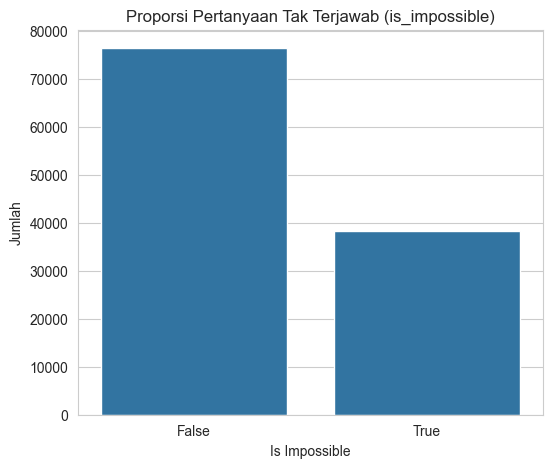

In [113]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='is_impossible')
plt.title('Proporsi Pertanyaan Tak Terjawab (is_impossible)')
plt.xlabel('Is Impossible')
plt.ylabel('Jumlah')

# Simpan gambar (opsional)
plt.savefig('is_impossible_count.png')
print("Grafik 'is_impossible_count.png' disimpan.")

# Tampilkan plot
plt.show()

## 🧹 Pemfilteran Data: Hanya Memproses Pasangan Q&A yang Dapat Dijawab

Modifikasi dari proses *flattening* sebelumnya. Tujuannya adalah untuk **mengabaikan** semua pertanyaan yang ditandai sebagai `is_impossible: True`, sehingga DataFrame akhir (`df`) hanya berisi sampel yang memiliki jawaban terverifikasi dalam teks konteks.

In [ ]:
# Proses untuk meratakan data
records = []
for doc in data['data']:
    for para in doc['paragraphs']:
        context = para['context']
        for qa in para['qas']:
            
            # --- MODIFIKASI KUNCI ---
            # Hanya proses data jika 'is_impossible' adalah False
            if not qa['is_impossible']:
                # Pastikan ada jawaban (seharusnya selalu ada jika not impossible)
                if qa['answers']:
                    answer = qa['answers'][0] # Ambil jawaban pertama
                    records.append({
                        'id': qa['id'],
                        'context': context,
                        'question': qa['question'],
                        'answer_text': answer['text'],
                        'answer_start': answer['answer_start'],
                        # Kita tidak perlu kolom 'is_impossible' lagi
                    })

# Buat DataFrame
df = pd.DataFrame(records)

print(f"Flattening selesai. Total {len(df)} Q&A pairs ditemukan.")
df.info()

Flattening selesai. Total 76444 Q&A pairs ditemukan.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76444 entries, 0 to 76443
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76444 non-null  object
 1   context       76444 non-null  object
 2   question      76444 non-null  object
 3   answer_text   76444 non-null  object
 4   answer_start  76444 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


## 📏 Analisis Panjang Teks Pasangan Q&A yang Dapat Dijawab

In [ ]:
print("Menghitung panjang teks (berdasarkan kata)...")

# Hitung jumlah kata untuk setiap kolom teks
df['context_len'] = df['context'].apply(lambda x: len(x.split()))
df['question_len'] = df['question'].apply(lambda x: len(x.split()))
df['answer_len'] = df['answer_text'].apply(lambda x: len(x.split()))

# Tampilkan 5 baris pertama dengan kolom baru
print(df.head())

Menghitung panjang teks (berdasarkan kata)...
                         id  \
0  56be85543aeaaa14008c9063   
1  56be85543aeaaa14008c9065   
2  56be85543aeaaa14008c9066   
3  56bf6b0f3aeaaa14008c9601   
4  56bf6b0f3aeaaa14008c9602   

                                             context  \
0  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
1  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
2  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
3  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   
4  Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ /...   

                                            question          answer_text  \
0                       Kapan Beyonce mulai populer?   pada akhir 1990-an   
1  Di bidang apa Beyonce bersaing ketika dia tumb...  menyanyi dan menari   
2  Kapan Beyonce meninggalkan Destiny's Child dan...                 2003   
3  Di kota dan negara bagian manakah Beyonce tumbuh?       Houston, Texas   
4       Pada dekade berapa Beyonce menjadi te

## 📈 Distribusi Panjang Konteks, Pertanyaan dan Jawaban

Grafik 'context_length_distribution_answered.png' disimpan.


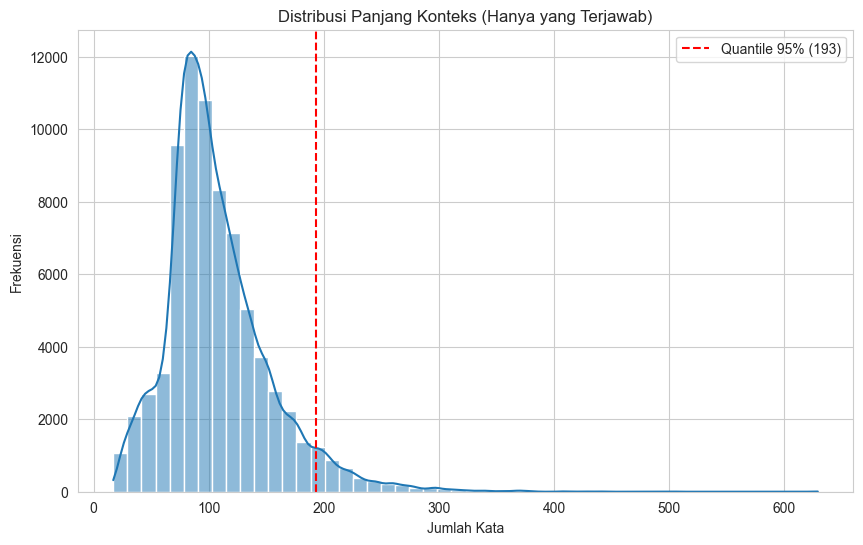

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['context_len'], bins=50, kde=True)
plt.title('Distribusi Panjang Konteks (Hanya yang Terjawab)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')

# Tambahkan garis vertikal di kuantil 95%
q95 = df['context_len'].quantile(0.95)
plt.axvline(q95, color='red', linestyle='--', label=f'Quantile 95% ({int(q95)})')
plt.legend()

# Simpan gambar (opsional)
plt.savefig('context_length_distribution_answered.png')
print("Grafik 'context_length_distribution_answered.png' disimpan.")

# Tampilkan plot
plt.show()

Grafik 'question_length_distribution_answered.png' disimpan.


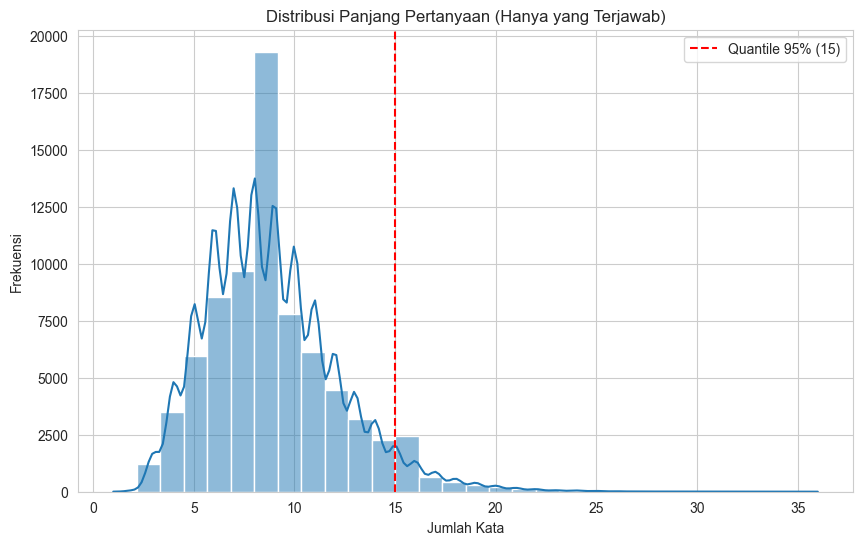

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['question_len'], bins=30, kde=True)
plt.title('Distribusi Panjang Pertanyaan (Hanya yang Terjawab)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')

# Tambahkan garis vertikal di kuantil 95%
q95 = df['question_len'].quantile(0.95)
plt.axvline(q95, color='red', linestyle='--', label=f'Quantile 95% ({int(q95)})')
plt.legend()

# Simpan gambar (opsional)
plt.savefig('question_length_distribution_answered.png')
print("Grafik 'question_length_distribution_answered.png' disimpan.")

# Tampilkan plot
plt.show()

Grafik 'answer_length_distribution_answered.png' disimpan.


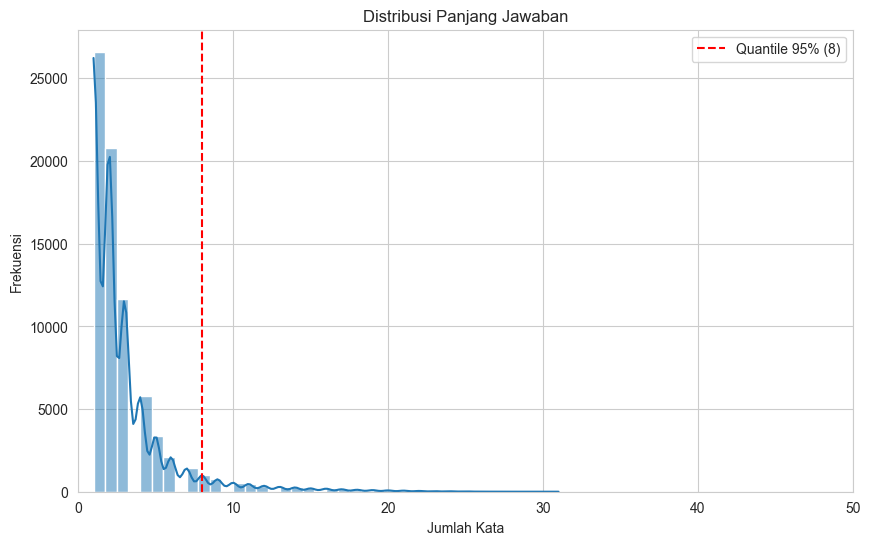

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['answer_len'], bins=40, kde=True)
plt.title('Distribusi Panjang Jawaban')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.xlim(0, 50) # Fokus pada jawaban yang lebih pendek (0-50 kata)

# Tambahkan garis vertikal di kuantil 95%
q95 = df['answer_len'].quantile(0.95)
plt.axvline(q95, color='red', linestyle='--', label=f'Quantile 95% ({int(q95)})')
plt.legend()

# Simpan gambar (opsional)
plt.savefig('answer_length_distribution_answered.png')
print("Grafik 'answer_length_distribution_answered.png' disimpan.")

# Tampilkan plot
plt.show()

## 💾 Ekstraksi Teks Mentah untuk Pelatihan Tokenizer

Langkah ini bertujuan untuk mengumpulkan semua teks (baik dari **Context** maupun **Question**) dari dataset SQuAD ke dalam satu file teks tunggal (`squad_text_for_tokenizer.txt`). File teks ini kemudian dapat digunakan sebagai korpus untuk melatih Tokenizer baru (misalnya, *Byte-Pair Encoding* atau *WordPiece*) yang disesuaikan dengan terminologi dan gaya bahasa dataset.

In [ ]:
# Tentukan path file
json_file_path = "train-SQuAD-id.json"
text_file_path = "squad_text_for_tokenizer.txt"

print(f"Membuka {json_file_path} untuk ekstraksi teks...")

with open(json_file_path, 'r', encoding='utf-8') as f_in:
    data = json.load(f_in)

# Buka file untuk menulis
with open(text_file_path, 'w', encoding='utf-8') as f_out:
    count = 0
    for doc in data['data']:
        for para in doc['paragraphs']:
            # Tulis konteks
            f_out.write(para['context'] + '\n')
            count += 1
            for qa in para['qas']:
                # Tulis pertanyaan
                f_out.write(qa['question'] + '\n')
                count += 1

print(f"Selesai. Total {count} baris teks (konteks & pertanyaan) diekstrak ke {text_file_path}")

Membuka train-SQuAD-id.json untuk ekstraksi teks...
Selesai. Total 131772 baris teks (konteks & pertanyaan) diekstrak ke squad_text_for_tokenizer.txt


## ⚙️ Pelatihan Tokenizer WordPiece Kustom

*Cell* ini melatih *tokenizer* baru menggunakan model **WordPiece** yang disesuaikan dengan korpus teks yang dibuat dari data SQuAD. *Tokenizer* ini akan memecah kata menjadi *subwords* (potongan kata) jika kata tersebut tidak ada dalam kosakata.

### Konfigurasi

* **Model:** WordPiece
* **Pra-Tokenisasi:** Berdasarkan spasi (`pre_tokenizers.Whitespace()`)
* **Ukuran Kosakata:** 30.000 token
* **Token Khusus:** `[PAD]`, `[UNK]`, `[CLS]`, `[SEP]`

In [ ]:
# Tentukan path untuk menyimpan tokenizer yang sudah dilatih
tokenizer_save_path = "squad-id-wordpiece.json"
text_file_path = "squad_text_for_tokenizer.txt"

# 1. Inisialisasi tokenizer WordPiece
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

# 2. Tentukan pre-tokenizer (bagaimana membagi teks sebelum subwording)
# Kita bagi berdasarkan spasi
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# 3. Inisialisasi pelatih (trainer)
# Kita targetkan 30.000 token
VOCAB_SIZE = 30000 
trainer = trainers.WordPieceTrainer(
    vocab_size=VOCAB_SIZE,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"]
)

print(f"Memulai pelatihan tokenizer dengan {VOCAB_SIZE} vocab size...")

# 4. Latih tokenizer
tokenizer.train([text_file_path], trainer)

# 5. Simpan tokenizer
tokenizer.save(tokenizer_save_path)

print(f"Pelatihan selesai! Tokenizer disimpan di: {tokenizer_save_path}")

Memulai pelatihan tokenizer dengan 30000 vocab size...
Pelatihan selesai! Tokenizer disimpan di: squad-id-wordpiece.json


## 🔬 Pengujian Tokenizer Kustom

*Cell* ini memuat *tokenizer* WordPiece yang disimpan dan mengujinya pada kalimat contoh. Tujuannya adalah untuk memverifikasi apakah *tokenizer* dapat memecah teks menjadi token-token kecil (*subword tokens*) dan mengonversinya menjadi ID numerik yang siap digunakan oleh model *machine learning*.

In [114]:
tokenizer_path = "squad-id-wordpiece.json"

# Muat tokenizer dari file
try:
    tokenizer = Tokenizer.from_file(tokenizer_path)
    print(f"Tokenizer berhasil dimuat dari {tokenizer_path}")

    # Uji coba pada kalimat contoh
    contoh_teks = "Kapan Beyoncé mulai populer di akhir 1990-an?"
    
    # Gunakan .encode() untuk mengubah teks menjadi token
    output = tokenizer.encode(contoh_teks)

    print(f"\n--- Uji Coba Tokenizer ---")
    print(f"Teks Asli:\n{contoh_teks}")
    
    print(f"\nSubword Tokens:\n{output.tokens}")
    
    print(f"\nToken IDs (Input untuk model):\n{output.ids}")
    
    print(f"\nToken '[UNK]' (ID 1): {tokenizer.id_to_token(1)}")
    
    # Contoh pemisahan subword
    print("\nContoh pemisahan subword:")
    output_beyonce = tokenizer.encode("Beyoncé")
    print(f"'Beyoncé' -> {output_beyonce.tokens}")
    
except Exception as e:
    print(f"Error: tidak dapat memuat tokenizer. Pastikan sel 3 berjalan sukses.")
    print(e)

Tokenizer berhasil dimuat dari squad-id-wordpiece.json

--- Uji Coba Tokenizer ---
Teks Asli:
Kapan Beyoncé mulai populer di akhir 1990-an?

Subword Tokens:
['Kapan', 'Beyoncé', 'mulai', 'populer', 'di', 'akhir', '1990', '-', 'an', '?']

Token IDs (Input untuk model):
[2298, 5191, 2710, 3362, 2064, 2581, 4292, 16, 2155, 34]

Token '[UNK]' (ID 1): [UNK]

Contoh pemisahan subword:
'Beyoncé' -> ['Beyoncé']


## ⚙️ Inisialisasi Konfigurasi dan Tokenizer

*Cell* ini menetapkan konstanta kunci untuk pemrosesan data, yaitu **panjang urutan maksimum** (`MAX_SEQ_LENGTH`), dan memuat kembali *tokenizer* WordPiece kustom.

Penghitungan panjang urutan maksimum didasarkan pada analisis statistik sebelumnya:
> $\text{Panjang Konteks}_{95\%} (\approx 192 \text{ kata}) + \text{Panjang Pertanyaan}_{95\%} (\approx 14 \text{ kata}) + \text{Token Khusus} (\approx 3 \text{ token}) \approx 209 \text{ token}$.
> Nilai **384** sering digunakan sebagai standar aman yang lebih besar.

In [115]:
# Tentukan panjang urutan maksimum
# Konteks (95% < 192) + Pertanyaan (95% < 14) + Token Khusus (~3) = ~209
# 384 adalah angka standar yang aman, memberi banyak ruang
MAX_SEQ_LENGTH = 384

# Muat tokenizer yang sudah kita latih
tokenizer_path = "squad-id-wordpiece.json"
tokenizer = Tokenizer.from_file(tokenizer_path)

# Dapatkan ID untuk token khusus kita
CLS_ID = tokenizer.token_to_id("[CLS]")
SEP_ID = tokenizer.token_to_id("[SEP]")
PAD_ID = tokenizer.token_to_id("[PAD]")

print(f"TensorFlow v{tf.__version__} dimuat.")
print(f"Tokenizer dimuat dari {tokenizer_path}")
print(f"MAX_SEQ_LENGTH diatur ke {MAX_SEQ_LENGTH}")

TensorFlow v2.20.0 dimuat.
Tokenizer dimuat dari squad-id-wordpiece.json
MAX_SEQ_LENGTH diatur ke 384


## 🧩 Fungsi Preprocessing Data SQuAD

Fungsi `preprocess_squad_data` mengambil data SQuAD JSON, melakukan tokenisasi, dan mengonversinya menjadi *input features* untuk model. Proses utama yang dilakukan adalah:

1.  **Pemformatan Input:** Menggabungkan pertanyaan dan konteks dengan format standar QA: `[CLS] Konteks [SEP] Pertanyaan [SEP]`.
2.  **Pemetaan Jawaban:** Mengonversi posisi jawaban dari indeks karakter ke indeks token.
3.  **Padding & Truncation:** Menyesuaikan panjang urutan menjadi `MAX_SEQ_LENGTH` (384) menggunakan *padding* atau *truncation*.
4.  **Pemfilteran:** Hanya memproses pasangan Q&A yang dapat dijawab (`is_impossible: False`) dan yang jawabannya tidak terpotong oleh batas `MAX_SEQ_LENGTH`.

In [116]:
def preprocess_squad_data(json_path, tokenizer, max_len):
    
    # Dapatkan ID token khusus
    cls_id = tokenizer.token_to_id("[CLS]")
    sep_id = tokenizer.token_to_id("[SEP]")
    pad_id = tokenizer.token_to_id("[PAD]")
    
    # Ini adalah list untuk menyimpan semua data yang sudah diproses
    all_input_ids = []
    all_attention_masks = []
    all_start_token_indices = []
    all_end_token_indices = []
    
    processed_count = 0
    skipped_count = 0

    print(f"Memulai preprocessing data dari {json_path}...")
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for doc in data['data']:
        for para in doc['paragraphs']:
            context = para['context']
            # Tokenisasi konteks SATU KALI
            context_encoding = tokenizer.encode(context)
            
            for qa in para['qas']:
                
                # === FILTER KUNCI ANDA DI SINI ===
                if not qa['is_impossible']:
                    
                    question = qa['question']
                    answer = qa['answers'][0] # Ambil jawaban pertama
                    answer_text = answer['text']
                    answer_start_char = answer['answer_start']
                    answer_end_char = answer_start_char + len(answer_text)
                    
                    # === PEMETAAN JAWABAN (Karakter -> Token) ===
                    # Temukan token start dan end di dalam *konteks*
                    token_start_index = context_encoding.char_to_token(answer_start_char)
                    token_end_index = context_encoding.char_to_token(answer_end_char - 1) # -1 karena inklusif
                    
                    # Jika pemetaan gagal (misal, jawaban hanya spasi), lewati
                    if token_start_index is None or token_end_index is None:
                        skipped_count += 1
                        continue
                        
                    # Tokenisasi pertanyaan
                    question_encoding = tokenizer.encode(question)
                    
                    # === MEMBUAT INPUT MODEL ===
                    # Format: [CLS] Konteks [SEP] Pertanyaan [SEP]
                    input_ids = [cls_id] + context_encoding.ids + [sep_id] + question_encoding.ids + [sep_id]
                    
                    # Sesuaikan indeks jawaban (karena kita menambahkan [CLS] di awal)
                    token_start_model = token_start_index + 1
                    token_end_model = token_end_index + 1
                    
                    # Buat attention mask (1 untuk token, 0 untuk padding)
                    attention_mask = [1] * len(input_ids)
                    
                    # === PADDING & TRUNCATION ===
                    if len(input_ids) >= max_len:
                        # Truncate (potong) dari kanan
                        input_ids = input_ids[:max_len]
                        attention_mask = attention_mask[:max_len]
                    else:
                        # Pad (tambah)
                        padding_length = max_len - len(input_ids)
                        input_ids = input_ids + ([pad_id] * padding_length)
                        attention_mask = attention_mask + ([0] * padding_length)
                    
                    # Cek terakhir: jika jawaban ada di luar input yang dipotong, lewati
                    if token_start_model >= max_len:
                        skipped_count += 1
                        continue
                        
                    # Pastikan end token tidak melewati batas (jika terpotong sebagian)
                    token_end_model = min(token_end_model, max_len - 1)
                        
                    # Tambahkan data yang berhasil diproses
                    all_input_ids.append(input_ids)
                    all_attention_masks.append(attention_mask)
                    all_start_token_indices.append(token_start_model)
                    all_end_token_indices.append(token_end_model)
                    processed_count += 1

    print(f"Preprocessing selesai.")
    print(f"Total data diproses (dijadikan input): {processed_count}")
    print(f"Total data dilewati (misal, jawaban terpotong): {skipped_count}")

    # Konversi ke format Numpy
    return {
        "input_ids": np.array(all_input_ids, dtype=np.int32),
        "attention_mask": np.array(all_attention_masks, dtype=np.int32),
        "start_positions": np.array(all_start_token_indices, dtype=np.int32),
        "end_positions": np.array(all_end_token_indices, dtype=np.int32)
    }

# Jalankan fungsi preprocessing
processed_data = preprocess_squad_data("train-SQuAD-id.json", tokenizer, MAX_SEQ_LENGTH)

Memulai preprocessing data dari train-SQuAD-id.json...
Preprocessing selesai.
Total data diproses (dijadikan input): 76425
Total data dilewati (misal, jawaban terpotong): 19


## ✅ Verifikasi Hasil Preprocessing

In [117]:
print(f"Bentuk data 'input_ids': {processed_data['input_ids'].shape}")
print(f"Bentuk data 'attention_mask': {processed_data['attention_mask'].shape}")
print(f"Bentuk data 'start_positions': {processed_data['start_positions'].shape}")
print(f"Bentuk data 'end_positions': {processed_data['end_positions'].shape}")

# Mari kita periksa data pertama
print("\n--- Memeriksa Sampel Data Pertama ---")

# Ambil data pertama
sample_input_ids = processed_data['input_ids'][0]
sample_start = processed_data['start_positions'][0]
sample_end = processed_data['end_positions'][0]

# Ubah ID kembali ke token
# Kita hanya akan menampilkan 60 token pertama agar tidak terlalu panjang
print(f"\nToken Input (60 token pertama):\n{tokenizer.decode(sample_input_ids[:60])}")

# Ekstrak token jawaban menggunakan indeks start/end
answer_tokens = sample_input_ids[sample_start : sample_end + 1]

# Decode token jawaban
decoded_answer = tokenizer.decode(answer_tokens)

print(f"\nPosisi Start (Token): {sample_start}")
print(f"Posisi End (Token): {sample_end}")
print(f"Token ID Jawaban: {answer_tokens}")
print(f"Teks Jawaban (hasil decode): '{decoded_answer}'")

Bentuk data 'input_ids': (76425, 384)
Bentuk data 'attention_mask': (76425, 384)
Bentuk data 'start_positions': (76425,)
Bentuk data 'end_positions': (76425,)

--- Memeriksa Sampel Data Pertama ---

Token Input (60 token pertama):
Beyoncé Gi ##sell ##e Know ##les - Carter (/ bi ##ː ##ˈ ##j ##ɒ ##ns ##e ##ɪ / be ##e - Y ##ON - say ) ( lahir 4 September 1981 ) adalah seorang penyanyi , penulis lagu , produser rekaman dan aktris Amerika . Dil ##ahir ##kan dan dibesarkan di Houston , Texas , ia tampil di berbagai

Posisi Start (Token): 71
Posisi End (Token): 75
Token ID Jawaban: [2127 2581 4292   16 2155]
Teks Jawaban (hasil decode): 'pada akhir 1990 - an'


## 📦 Membuat `tf.data.Dataset`

Langkah ini mengonversi array NumPy hasil *preprocessing* menjadi objek **`tf.data.Dataset`**. Format ini sangat dianjurkan saat melatih model TensorFlow/Keras karena memungkinkan *pipelining*, *shuffling*, dan *batching* yang efisien, yang diperlukan untuk pelatihan model *Deep Learning*.

Input (`features`) dan output (`labels`) dikemas menjadi *tuple* tunggal `(features, labels)`, yang merupakan format standar untuk metode Keras `model.fit()`.

In [118]:
print("Membuat tf.data.Dataset dari numpy arrays...")

# Buat dictionary untuk input (fitur)
# Model kita akan memiliki 2 input: input_ids dan attention_mask
features = {
    "input_ids": processed_data['input_ids'],
    "attention_mask": processed_data['attention_mask']
}

# Buat dictionary untuk output (label)
# Model kita akan memiliki 2 output: start_positions dan end_positions
labels = {
    "start_positions": processed_data['start_positions'],
    "end_positions": processed_data['end_positions']
}

# Buat dataset (features, labels)
# Ini adalah format standar yang disukai oleh model.fit() Keras
try:
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    print("Dataset (features, labels) berhasil dibuat.")
    
    # Mari kita lihat satu elemen untuk verifikasi
    print("\nStruktur satu elemen dataset (features, labels):")
    for (batch_features, batch_labels) in dataset.take(1):
        print("\nFeatures:")
        print(f"  input_ids (shape): {batch_features['input_ids'].shape}")
        print(f"  attention_mask (shape): {batch_features['attention_mask'].shape}")
        
        print("\nLabels:")
        print(f"  start_positions (value): {batch_labels['start_positions']}")
        print(f"  end_positions (value): {batch_labels['end_positions']}")

except Exception as e:
    print(f"Gagal membuat dataset. Pastikan 'processed_data' terdefinisi.")
    print(e)

Membuat tf.data.Dataset dari numpy arrays...
Dataset (features, labels) berhasil dibuat.

Struktur satu elemen dataset (features, labels):

Features:
  input_ids (shape): (384,)
  attention_mask (shape): (384,)

Labels:
  start_positions (value): 71
  end_positions (value): 75


## 🔪 Pembagian Data Menjadi Train, Validation, dan Test Set

*Cell* ini menghitung ukuran masing-masing set data (Train, Validation, Test) menggunakan rasio 80:10:10. Pembagian dilakukan pada `tf.data.Dataset` yang sudah diacak (*shuffled*) terlebih dahulu untuk memastikan representasi data yang merata di setiap set.

In [119]:
# Tentukan ukuran dataset
total_data_size = len(processed_data['input_ids'])

# Tentukan rasio untuk validasi (10%) dan test (10%)
validation_split = 0.1
test_split = 0.1

# Hitung jumlah data untuk setiap set
validation_size = int(total_data_size * validation_split)
test_size = int(total_data_size * test_split)
train_size = total_data_size - validation_size - test_size

print(f"Total data: {total_data_size}")
print(f"Ukuran Train: {train_size} (80%)")
print(f"Ukuran Validasi: {validation_size} (10%)")
print(f"Ukuran Test: {test_size} (10%)")

# Acak (shuffle) dataset SEBELUM membaginya
# buffer_size=total_data_size berarti kita mengacak seluruh dataset
dataset = dataset.shuffle(buffer_size=total_data_size, seed=42)

# Bagi dataset menggunakan .take() dan .skip()
# 1. Ambil validation_dataset (10% pertama)
validation_dataset = dataset.take(validation_size)

# 2. Lewati 10% validasi, lalu ambil 10% berikutnya untuk test
test_dataset = dataset.skip(validation_size).take(test_size)

# 3. Lewati 20% (validasi + test) dan ambil sisanya (80%) untuk train
train_dataset = dataset.skip(validation_size + test_size)

print("\nDataset berhasil dibagi menjadi train_dataset, validation_dataset, dan test_dataset.")

Total data: 76425
Ukuran Train: 61141 (80%)
Ukuran Validasi: 7642 (10%)
Ukuran Test: 7642 (10%)

Dataset berhasil dibagi menjadi train_dataset, validation_dataset, dan test_dataset.


## 🚀 Persiapan Pipeline Data (`tf.data.Dataset`)

In [120]:
# Tentukan ukuran BATCH_SIZE
BATCH_SIZE = 6

# Siapkan pipeline pelatihan
train_dataset = (
    train_dataset
    .repeat()  # Ulangi dataset selamanya (untuk epoch)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE) # Optimasi otomatis
)

# Siapkan pipeline validasi
validation_dataset = (
    validation_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Siapkan pipeline test
test_dataset = (
    test_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Pipeline data selesai disiapkan dengan BATCH_SIZE={BATCH_SIZE}")
print("Kita sekarang memiliki 3 dataset yang siap digunakan:")
print("1. train_dataset (untuk model.fit)")
print("2. validation_dataset (untuk model.fit 'validation_data')")
print("3. test_dataset (untuk model.evaluate setelah selesai)")

# Verifikasi batch dari train_dataset
print("\nVerifikasi satu batch dari train_dataset:")
for (batch_features, batch_labels) in train_dataset.take(1):
    print("\nFeatures (satu batch):")
    print(f"  input_ids (shape): {batch_features['input_ids'].shape}")
    print(f"  attention_mask (shape): {batch_features['attention_mask'].shape}")
    
    print("\nLabels (satu batch):")
    print(f"  start_positions (shape): {batch_labels['start_positions'].shape}")
    print(f"  end_positions (shape): {batch_labels['end_positions'].shape}")

Pipeline data selesai disiapkan dengan BATCH_SIZE=6
Kita sekarang memiliki 3 dataset yang siap digunakan:
1. train_dataset (untuk model.fit)
2. validation_dataset (untuk model.fit 'validation_data')
3. test_dataset (untuk model.evaluate setelah selesai)

Verifikasi satu batch dari train_dataset:

Features (satu batch):
  input_ids (shape): (6, 384)
  attention_mask (shape): (6, 384)

Labels (satu batch):
  start_positions (shape): (6,)
  end_positions (shape): (6,)


In [121]:
from tensorflow.keras.layers import MultiHeadAttention

## Definisi Arsitektur Model Transformer QA (Encoder-Only)

*Cell* ini mendefinisikan lapisan-lapisan kustom (seperti Positional Encoding dan FeedForward) yang diperlukan untuk membangun arsitektur Transformer. Semua lapisan ini menyertakan metode `get_config` untuk memastikan kompatibilitas penuh dengan API serialisasi Keras/TensorFlow, yang penting untuk menyimpan bobot model.

In [122]:
# === PositionalEncoding (DIPERBAIKI + SERIALIZABLE) ===
class PositionalEncoding(Layer):
    """Implementasi Positional Encoding (Bagian 3.5)"""
    def __init__(self, d_model, dropout=0.1, max_len=5000, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout
        self.max_len = max_len
        self.dropout = Dropout(dropout)

        pe = np.zeros((max_len, d_model))
        position = np.arange(0, max_len, dtype=np.float32).reshape(-1, 1)
        div_term = np.exp(
            np.arange(0, d_model, 2, dtype=np.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe.reshape(1, max_len, d_model)
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x, training=False):
        seq_len = tf.shape(x)[1]
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x, training=training)

    def compute_output_shape(self, input_shape):
        return input_shape
    
    # Tambahkan get_config untuk serialisasi
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "dropout": self.dropout_rate,
            "max_len": self.max_len,
        })
        return config


# === PositionwiseFeedForward (TAMBAHKAN GET_CONFIG) ===
class PositionwiseFeedForward(Layer):
    """Implementasi FFN (Bagian 3.3)"""
    def __init__(self, d_model, d_ff, dropout=0.1, **kwargs):
        super(PositionwiseFeedForward, self).__init__(**kwargs)
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout
        
        self.w_1 = Dense(d_ff)
        self.w_2 = Dense(d_model)
        self.relu = ReLU()
        self.dropout = Dropout(dropout)

    def call(self, x, training=False):
        x = self.w_1(x)
        x = self.relu(x)
        x = self.dropout(x, training=training)
        x = self.w_2(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "d_ff": self.d_ff,
            "dropout": self.dropout_rate,
        })
        return config


# === EncoderLayer (TAMBAHKAN GET_CONFIG) ===
class EncoderLayer(Layer):
    """Satu lapisan Encoder (Bagian 3.1)"""
    def __init__(self, d_model, h, d_ff, dropout=0.1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.h = h
        self.d_ff = d_ff
        self.dropout_rate = dropout
        
        self.mha = MultiHeadAttention(
            num_heads=h,
            key_dim=d_model // h,
            dropout=dropout,
            name="multi_head_attention"
        )
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, x, mask, training=False):
        # Ubah mask 2D -> 4D untuk MHA
        mha_mask = None
        if mask is not None:
            mha_mask = mask[:, tf.newaxis, tf.newaxis, :]

        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mha_mask,
            training=training
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "h": self.h,
            "d_ff": self.d_ff,
            "dropout": self.dropout_rate,
        })
        return config


# === Encoder (TAMBAHKAN GET_CONFIG) ===
class Encoder(Layer):
    """Tumpukan N lapisan Encoder (Bagian 3.1)"""
    def __init__(self, N, d_model, h, d_ff, dropout=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.N = N
        self.d_model = d_model
        self.h = h
        self.d_ff = d_ff
        self.dropout_rate = dropout
        
        self.layers = [
            EncoderLayer(d_model, h, d_ff, dropout, name=f"encoder_layer_{i}")
            for i in range(N)
        ]
        self.norm = LayerNormalization(epsilon=1e-6)

    def call(self, x, mask, training=False):
        for i in range(self.N):
            x = self.layers[i](x, mask, training=training)
        return self.norm(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "N": self.N,
            "d_model": self.d_model,
            "h": self.h,
            "d_ff": self.d_ff,
            "dropout": self.dropout_rate,
        })
        return config


print("Semua lapisan (Layer) kustom [VERSI SERIALIZABLE] telah didefinisikan.")


# === Build Model Function ===
def build_transformer_qa_model(
    vocab_size, 
    N=6, 
    d_model=512, 
    d_ff=2048, 
    h=8, 
    dropout=0.1,
    max_seq_length=384
):
    """Merakit Model QA Encoder-Only Transformer"""
    
    # Input layers
    input_ids = Input(shape=(max_seq_length,), dtype="int32", name="input_ids")
    attention_mask_input = Input(shape=(max_seq_length,), dtype="int32", name="attention_mask")
    
    # Embedding layer dengan scaling
    embedding_layer = Embedding(vocab_size, d_model, name="embeddings")
    embedded_tokens = embedding_layer(input_ids)
    embedded_tokens *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Positional encoding
    pos_encoding_layer = PositionalEncoding(d_model, dropout, max_len=max_seq_length, name="pos_encoding")
    x = pos_encoding_layer(embedded_tokens)
    
    # Encoder stack
    encoder_stack = Encoder(N, d_model, h, d_ff, dropout, name="encoder_stack")
    encoded_output = encoder_stack(x, attention_mask_input)
    
    # QA Head: Dense layer dengan 2 output units
    qa_head = Dense(2, name="qa_head")
    logits = qa_head(encoded_output)  # Shape: (batch, seq_len, 2)
    
    # Split menjadi start dan end logits
    start_logits = logits[..., 0]
    end_logits = logits[..., 1]
    
    # Build model
    model = Model(
        inputs={"input_ids": input_ids, "attention_mask": attention_mask_input}, 
        outputs={"start_positions": start_logits, "end_positions": end_logits},
        name="transformer_qa_model"
    )
    
    return model


print("Fungsi 'build_transformer_qa_model' [VERSI SERIALIZABLE] telah didefinisikan.")


Semua lapisan (Layer) kustom [VERSI SERIALIZABLE] telah didefinisikan.
Fungsi 'build_transformer_qa_model' [VERSI SERIALIZABLE] telah didefinisikan.


## 🛠️ Fungsi Pembuatan Model Transformer QA

*Cell* ini berisi fungsi lengkap **`build_transformer_qa_model`** yang merakit arsitektur *Encoder-Only Transformer* (menggunakan lapisan kustom yang didefinisikan sebelumnya: `PositionalEncoding`, `Encoder`, dll.) untuk tugas *Question Answering* (QA) tipe ekstraktif.

Model ini mengambil `input_ids` dan `attention_mask` dan menghasilkan dua output logit:
1.  **`start_positions`**: Logit untuk setiap token, memprediksi kemungkinan token tersebut adalah *token awal* jawaban.
2.  **`end_positions`**: Logit untuk setiap token, memprediksi kemungkinan token tersebut adalah *token akhir* jawaban.

In [123]:
def build_transformer_qa_model(
    vocab_size, 
    N=6, 
    d_model=512, 
    d_ff=2048, 
    h=8, 
    dropout=0.1,
    max_seq_length=384
):
    """
    Merakit Model QA Encoder-Only Transformer
    
    Args:
        vocab_size: Ukuran vocabulary
        N: Jumlah encoder layers
        d_model: Dimensi model
        d_ff: Dimensi feed-forward network
        h: Jumlah attention heads
        dropout: Dropout rate
        max_seq_length: Panjang maksimum sequence
    
    Returns:
        Model Keras dengan 2 output: start_positions dan end_positions
    """
    
    # Input layers
    input_ids = Input(shape=(max_seq_length,), dtype="int32", name="input_ids")
    attention_mask_input = Input(shape=(max_seq_length,), dtype="int32", name="attention_mask")
    
    # Embedding layer dengan scaling
    embedding_layer = Embedding(vocab_size, d_model, name="embeddings")
    embedded_tokens = embedding_layer(input_ids)
    embedded_tokens *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Positional encoding
    pos_encoding_layer = PositionalEncoding(d_model, dropout, max_len=max_seq_length, name="pos_encoding")
    x = pos_encoding_layer(embedded_tokens)
    
    # Encoder stack
    encoder_stack = Encoder(N, d_model, h, d_ff, dropout, name="encoder_stack")
    encoded_output = encoder_stack(x, attention_mask_input)
    
    # QA Head: Dense layer dengan 2 output units
    qa_head = Dense(2, name="qa_head")
    logits = qa_head(encoded_output)  # Shape: (batch, seq_len, 2)
    
    # Split menjadi start dan end logits menggunakan indexing
    start_logits = logits[..., 0]  # Shape: (batch, seq_len)
    end_logits = logits[..., 1]    # Shape: (batch, seq_len)
    
    # Build model
    model = Model(
        inputs={"input_ids": input_ids, "attention_mask": attention_mask_input}, 
        outputs={"start_positions": start_logits, "end_positions": end_logits},
        name="transformer_qa_model"
    )
    
    return model

print("Fungsi 'build_transformer_qa_model_simplified' [VERSI DIPERBAIKI LENGKAP] telah didefinisikan.")

Fungsi 'build_transformer_qa_model_simplified' [VERSI DIPERBAIKI LENGKAP] telah didefinisikan.


## 🤖 Inisialisasi Model Transformer QA

In [124]:
# === Inisialisasi Model ===
VOCAB_SIZE = tokenizer.get_vocab_size()
N_LAYERS = 2
D_MODEL = 256
D_FF = 1024
N_HEADS = 4
DROPOUT = 0.1
MAX_SEQ_LENGTH = 384

print("Menginisialisasi model...")
model = build_transformer_qa_model(
    vocab_size=VOCAB_SIZE,
    N=N_LAYERS,
    d_model=D_MODEL,
    d_ff=D_FF,
    h=N_HEADS,
    dropout=DROPOUT,
    max_seq_length=MAX_SEQ_LENGTH
)

# Tampilkan ringkasan
model.summary()

print("\n✅ Model siap untuk dikompilasi dan dilatih!")

Menginisialisasi model...


Model: "transformer_qa_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings          │ (None, 384, 256)  │  7,680,000 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 384, 256)  │          0 │ embeddings[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_encoding        │ (None, 384, 256)  │          0 │ multiply_3[0][0]  │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_stack       │ (None, 384, 256)  │  1,580,032 │ pos_encoding[0][… │
│ (Encoder)           │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ qa_head (Dense)     │ (None, 384, 2)    │        514 │ encoder_stack[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 384)       │          0 │ qa_head[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 384)       │          0 │ qa_head[0][0]     │
│ (GetItem)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,260,546 (35.33 MB)

 Trainable params: 9,260,546 (35.33 MB)

 Non-trainable params: 0 (0.00 B)


✅ Model siap untuk dikompilasi dan dilatih!


## ⚙️ Implementasi Learning Rate Schedule & Kompilasi Model

In [127]:
# 1. Implementasi Jadwal Learning Rate Kustom
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(CustomSchedule, self).__init__(**kwargs)
        self.d_model = d_model
        self.warmup_steps = warmup_steps

        self.d_model_float = tf.cast(self.d_model, tf.float32)
        
    def __call__(self, step):
        # Rumus dari paper
        step = tf.cast(step, tf.float32)
        step = tf.maximum(step, 1.0)
        
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model_float) * tf.math.minimum(arg1, arg2)
    def get_config(self):
        """Method untuk serialisasi - WAJIB ADA"""
        return {
            "d_model": int(self.d_model),
            "warmup_steps": int(self.warmup_steps)
        }
    
    @classmethod
    def from_config(cls, config):
        """Method untuk deserialisasi - OPSIONAL tapi direkomendasikan"""
        return cls(**config)

# 2. Tentukan Optimizer (sesuai paper)
# Gunakan d_model=512 dan warmup_steps=4000
learning_rate = CustomSchedule(D_MODEL, warmup_steps=4000)

# Gunakan Adam optimizer dengan parameter dari paper
optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9,      #
    beta_2=0.98,      #
    epsilon=1e-9     #
)

# 3. Tentukan Loss Function
# Kita punya 2 output, jadi kita butuh 2 loss.
# Gunakan 'Sparse' karena label kita adalah integer tunggal (indeks), bukan one-hot.
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 4. Tentukan Metrik
# Kita ingin memantau akurasi untuk posisi start dan end
metrics = {
    'start_positions': 'sparse_categorical_accuracy',
    'end_positions': 'sparse_categorical_accuracy'
}

# 5. Kompilasi Model
# Asumsikan model Anda bernama 'model' dari sel sebelumnya
model.compile(
    optimizer=optimizer,
    loss={
        'start_positions': loss_function,
        'end_positions': loss_function
    },
    metrics=metrics
)

print(f"Model berhasil dikompilasi dengan optimizer Adam.")
print(f"Loss: SparseCategoricalCrossentropy")
print(f"Metrics: SparseCategoricalAccuracy")

Model berhasil dikompilasi dengan optimizer Adam.
Loss: SparseCategoricalCrossentropy
Metrics: SparseCategoricalAccuracy


## 🏃‍♂️ Konfigurasi Pelatihan dan Callbacks

*Cell* ini mendefinisikan konstanta pelatihan seperti *epochs* dan *batch size*, menghitung jumlah langkah per *epoch* dan validasi (menggunakan subset data untuk pengujian cepat), dan menyiapkan *callbacks* Keras yang esensial:

1.  **`ModelCheckpoint`**: Menyimpan model yang memberikan kinerja terbaik pada data validasi (`val_loss`).
2.  **`EarlyStopping`**: Mencegah *overfitting* dan menghemat waktu komputasi dengan menghentikan pelatihan jika kinerja validasi tidak membaik setelah beberapa *epoch* (`patience=3`).

In [ ]:
# Tentukan konstanta pelatihan
EPOCHS = 20 # Anda bisa mulai dengan 10-20, lalu tambah jika perlu
BATCH_SIZE = 6

# Kita perlu menghitung 'steps_per_epoch' dan 'validation_steps'
# Berdasarkan output preprocessing Anda sebelumnya:
# Total data: 76425
# Split: 80% Train, 10% Validasi, 10% Test

total_data_size = 76425
validation_size = int(total_data_size * 0.1)  # 7642
test_size = int(total_data_size * 0.1)        # 7642
train_size = total_data_size - validation_size - test_size # 61141

data_train_sample = 10000
data_val_sample = 2000
# Hitung steps
steps_per_epoch = data_train_sample // BATCH_SIZE
validation_steps = data_val_sample // BATCH_SIZE

print(f"Total Data Latih: {train_size}")
print(f"Total Data Validasi: {validation_size}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Steps per Epoch: {steps_per_epoch}")
print(f"Validation Steps: {validation_steps}")

train_subset = train_dataset.take(steps_per_epoch)
validation_subset = validation_dataset.take(validation_steps)

# 1. Tentukan Callbacks
# Callback untuk menyimpan model terbaik berdasarkan val_loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="transformer_squad_terbaik.keras", # Nama file untuk menyimpan
    save_weights_only=False,
    monitor='val_loss', # Pantau loss validasi
    mode='min',
    save_best_only=True, # Hanya simpan yang terbaik
    verbose=1
)

# Callback untuk menghentikan pelatihan jika tidak ada kemajuan
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, # Hentikan jika 3 epoch tidak ada kemajuan
    verbose=1,
    restore_best_weights=True
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback]

Total Data Latih: 61141
Total Data Validasi: 7642
Epochs: 20
Batch Size: 6
Steps per Epoch: 1666
Validation Steps: 333


## Memulai Pelatihan Model (Fitting)

In [ ]:
print("Memulai pelatihan model 'from scratch'...")
print("PERINGATAN: Ini akan memakan waktu sangat lama tanpa GPU.")

# Asumsikan 'model', 'train_dataset', dan 'validation_dataset' sudah ada
# dari langkah-langkah preprocessing Anda

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_subset,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

print("\n--- Pelatihan 'From Scratch' Selesai ---")
print("Model terbaik Anda telah disimpan sebagai 'transformer_squad_from_scratch.keras'")

Memulai pelatihan model 'from scratch'...
PERINGATAN: Ini akan memakan waktu sangat lama tanpa GPU.
Epoch 1/20
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - end_positions_loss: 5.0673 - end_positions_sparse_categorical_accuracy: 0.0234 - loss: 10.2146 - start_positions_loss: 5.1473 - start_positions_sparse_categorical_accuracy: 0.0201
Epoch 1: val_loss improved from None to 8.93133, saving model to transformer_squad_terbaik.keras
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 287s 170ms/step - end_positions_loss: 4.7293 - end_positions_sparse_categorical_accuracy: 0.0356 - loss: 9.4273 - start_positions_loss: 4.6980 - start_positions_sparse_categorical_accuracy: 0.0295 - val_end_positions_loss: 4.4975 - val_end_positions_sparse_categorical_accuracy: 0.0551 - val_loss: 8.9313 - val_start_positions_loss: 4.4338 - val_start_positions_sparse_categorical_accuracy: 0.0536
Epoch 2/20
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - end_positions_loss: 4.5060 - end_positions_sparse_categorical_accuracy: 0.0458

## 💾 Konfigurasi Pemulihan Model

*Cell* ini mendefinisikan *dictionary* `custom_objects` yang berisi semua kelas lapisan dan jadwal *learning rate* kustom yang digunakan dalam model. Ini **mutlak diperlukan** saat memuat model Keras yang disimpan menggunakan format `.keras` atau H5 jika model tersebut menggunakan lapisan kustom, karena Keras perlu tahu bagaimana merekonstruksi lapisan-lapisan tersebut.

In [ ]:
custom_objects = {
    "PositionalEncoding": PositionalEncoding,
    "EncoderLayer": EncoderLayer,
    "Encoder": Encoder,
    "PositionwiseFeedForward": PositionwiseFeedForward,
    "CustomSchedule": CustomSchedule  # Penting untuk memuat optimizer
}

# 2. Tentukan Path Model
model_path = "transformer_squad_terbaik.keras"

## 📥 Memuat Model dan Tokenizer yang Telah Dilatih

In [ ]:
#3. Muat Model
try:
    print(f"Memuat model terlatih dari {model_path}...")
    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    print("Model berhasil dimuat!")
    
    # Muat tokenizer juga (kita membutuhkannya untuk pre/post-processing)
    tokenizer_path = "squad-id-wordpiece.json"
    tokenizer = Tokenizer.from_file(tokenizer_path)
    print(f"Tokenizer berhasil dimuat dari {tokenizer_path}")

except Exception as e:
    print(f"Gagal memuat model: {e}")
    print("\nPASTIKAN:")
    print("1. File 'mini_transformer_squad.keras' ada di direktori yang sama.")
    print("2. Semua sel yang mendefinisikan kelas (PositionalEncoding, EncoderLayer, CustomSchedule, dll.) telah dijalankan.")

Memuat model terlatih dari transformer_squad_terbaik.keras...


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'encoder_stack', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model berhasil dimuat!
Tokenizer berhasil dimuat dari squad-id-wordpiece.json


## ⚙️ Fungsi Preprocessing untuk Inferensi

*Cell* ini mendefinisikan fungsi **`preprocess_for_prediction`** yang mengambil teks mentah (`context` dan `question`), dan mengonversinya menjadi format tensor yang tepat untuk *input* model Keras/TensorFlow.

In [ ]:
# Asumsikan MAX_SEQ_LENGTH dan tokenizer sudah ada dari sel sebelumnya
# MAX_SEQ_LENGTH = 384
# tokenizer = ...

def preprocess_for_prediction(context, question, tokenizer, max_len):
    """Mengubah teks mentah menjadi input model."""
    
    cls_id = tokenizer.token_to_id("[CLS]")
    sep_id = tokenizer.token_to_id("[SEP]")
    pad_id = tokenizer.token_to_id("[PAD]")
    
    # 1. Tokenisasi
    context_encoding = tokenizer.encode(context)
    question_encoding = tokenizer.encode(question)
    
    # 2. Gabungkan & Buat Input ID
    # [CLS] Konteks [SEP] Pertanyaan [SEP]
    input_ids = [cls_id] + context_encoding.ids + [sep_id] + question_encoding.ids + [sep_id]
    
    # 3. Buat Attention Mask
    attention_mask = [1] * len(input_ids)
    
    # 4. Padding / Truncation
    if len(input_ids) >= max_len:
        input_ids = input_ids[:max_len]
        attention_mask = attention_mask[:max_len]
    else:
        padding_length = max_len - len(input_ids)
        input_ids = input_ids + ([pad_id] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
        
    # 5. Konversi ke TensorFlow Tensor (dengan batch dimension = 1)
    input_ids_tensor = tf.constant([input_ids], dtype=tf.int32)
    attention_mask_tensor = tf.constant([attention_mask], dtype=tf.int32)
    
    # Simpan token-token ini untuk post-processing
    original_tokens = input_ids 
    
    return {
        "input_ids": input_ids_tensor, 
        "attention_mask": attention_mask_tensor
    }, original_tokens

print("Fungsi 'preprocess_for_prediction' telah didefinisikan.")

Fungsi 'preprocess_for_prediction' telah didefinisikan.


## 🔮 Fungsi Inferensi: `predict_answer`

*Cell* ini mendefinisikan fungsi kunci untuk alur kerja *Question Answering* (QA). Fungsi **`predict_answer`** merangkum seluruh proses:

In [ ]:
def predict_answer(context, question, model, tokenizer, max_len=384):
    """Pipeline lengkap: Teks -> Prediksi -> Teks"""
    
    # 1. Preprocessing
    model_input, original_tokens = preprocess_for_prediction(context, question, tokenizer, max_len)
    
    # 2. Prediksi
    # model.predict() mengembalikan dictionary (sesuai nama output layer kita)
    predictions = model.predict(model_input)
    
    start_logits = predictions['start_positions'][0] # Ambil batch 0
    end_logits = predictions['end_positions'][0]   # Ambil batch 0
    
    # 3. Post-processing: Temukan token terbaik
    # Dapatkan indeks token dengan skor (logit) tertinggi
    pred_start_token = np.argmax(start_logits)
    pred_end_token = np.argmax(end_logits)
    
    # 4. Logika Sederhana: Pastikan start <= end
    if pred_start_token > pred_end_token:
        # Jika model salah (misal, pred_start=50, pred_end=20),
        # kita anggap jawaban tidak ditemukan / tidak valid
        return "[Jawaban tidak ditemukan (pred_start > pred_end)]"
        
    # 5. Decode Jawaban
    # Ekstrak token ID jawaban dari input asli
    answer_token_ids = original_tokens[pred_start_token : pred_end_token + 1]
    
    # Ubah token ID kembali menjadi teks
    answer_text = tokenizer.decode(answer_token_ids)
    
    return answer_text

print("Fungsi 'predict_answer' telah didefinisikan.")

Fungsi 'predict_answer' telah didefinisikan.


## 🧪 Uji Coba Inferensi Model

*Cell* ini menjalankan serangkaian pertanyaan terhadap dua blok konteks berbeda (`konteks_uji` dan `konteks_uji2`) menggunakan fungsi `predict_answer` yang telah didefinisikan.

In [ ]:
# === Uji Coba Model dengan Pertanyaan Baru ===
konteks_uji = """
Beyoncé Giselle Knowles-Carter (lahir 4 September 1981) adalah seorang penyanyi, penulis lagu, 
produser rekaman dan aktris Amerika. Dilahirkan dan dibesarkan di Houston, Texas, 
ia tampil di berbagai kompetisi menyanyi dan menari saat kecil. 
Dia menjadi terkenal pada akhir 1990-an sebagai penyanyi utama dari grup 
R&B wanita Destiny's Child.
"""
konteks_uji2 = """ 
Leonardo Wilhelm DiCaprio (lahir 11 November 1974) adalah seorang aktor dan produser film asal Amerika Serikat. 
Dikenal karena karyanya dalam film biografi dan periode, ia adalah penerima berbagai penghargaan, termasuk satu Academy Awards, 
satu British Academy Film Award dan tiga Golden Globe Awards. Pada tahun 2019, film-filmnya telah meraup lebih dari $7,2 miliar di 
seluruh dunia, dan ia telah ditempatkan delapan kali dalam peringkat tahunan aktor dengan bayaran tertinggi di dunia.
"""

pertanyaan_uji_1 = "Kapan Beyoncé lahir?"
pertanyaan_uji_2 = "Kapan Beyoncé menjadi terkenal?"
pertanyaan_uji_3 = "Siapa nama lengkap Beyoncé?"
pertanyaan_uji_4 = "Dimana Beyoncé dibesarkan?"

question_test_1 = "Kapan Leonardo DiCaprio lahir?"
question_test_2 = "Berapa banyak penghargaan Golden Globe yang dimiliki Leonardo DiCaprio?"
question_test_3 = "Siapa nama lengkap Leonardo DiCaprio?"

# Gunakan 'loaded_model' dan 'tokenizer' dari Cell 1
jawaban_1 = predict_answer(konteks_uji, pertanyaan_uji_1, loaded_model, tokenizer, MAX_SEQ_LENGTH)
jawaban_2 = predict_answer(konteks_uji, pertanyaan_uji_2, loaded_model, tokenizer, MAX_SEQ_LENGTH)
jawaban_3 = predict_answer(konteks_uji, pertanyaan_uji_3, loaded_model, tokenizer, MAX_SEQ_LENGTH)
jawaban_4 = predict_answer(konteks_uji, pertanyaan_uji_4, loaded_model, tokenizer, MAX_SEQ_LENGTH)

answer_test_1 = predict_answer(konteks_uji2, question_test_1, loaded_model, tokenizer, MAX_SEQ_LENGTH)
answer_test_2 = predict_answer(konteks_uji2, question_test_2, loaded_model, tokenizer, MAX_SEQ_LENGTH)
answer_test_3 = predict_answer(konteks_uji2, question_test_3, loaded_model, tokenizer, MAX_SEQ_LENGTH)

print(f"Q: {pertanyaan_uji_1}")
print(f"A: {jawaban_1}\n")

print(f"Q: {pertanyaan_uji_2}")
print(f"A: {jawaban_2}\n")

print(f"Q: {pertanyaan_uji_3}")
print(f"A: {jawaban_3}\n")

print(f"Q: {pertanyaan_uji_4}")
print(f"A: {jawaban_4}\n")

print(f"Q: {question_test_1}")
print(f"A: {answer_test_1}\n")

print(f"Q: {question_test_2}")
print(f"A: {answer_test_2}\n")

print(f"Q: {question_test_3}")
print(f"A: {answer_test_3}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Q: Kapan Beyoncé lahir?
A: 1990 - an

Q: Kapan Beyoncé menjadi terkenal?
A: 1990 - an

Q: Siapa nama lengkap Beyoncé?
A: ##sell ##e

Q: Dimana Beyoncé dibesarkan?
A: [Jawaban tidak ditemukan (pred_start > pred_end)]

Q: Kapan Leonardo DiCaprio lahir?
A: 1974

Q: Berapa banyak penghargaan Golden Globe yang dimiliki Leonardo DiCaprio?
A: $ 7 , 2 miliar

Q: Siapa nama lengkap Leonardo DiCaprio?
A: Wilhelm Di ##C ##ap ##rio ( lahir 11 November 1974 )



## 🔢 Perhitungan Langkah Evaluasi Uji (*Test Steps*)

*Cell* ini menghitung jumlah langkah (`test_steps`) yang diperlukan untuk mengevaluasi seluruh set data pengujian (*test set*). Kami memastikan bahwa bahkan jika *test size* tidak habis dibagi `BATCH_SIZE`, langkah ekstra akan ditambahkan untuk memastikan semua data dievaluasi.

In [ ]:
# Asumsikan total_data_size = 76425 (dari preprocessing)
# Asumsikan BATCH_SIZE = 8 (atau 4, atau 16, SESUAIKAN dengan yang Anda gunakan)

try:
    # Hitung test_size (10% dari total)
    test_size = int(total_data_size * 0.1) 
    
    # Hitung test_steps
    if BATCH_SIZE > 0:
        test_steps = test_size // BATCH_SIZE
        # Tambah 1 jika ada sisa (untuk memastikan semua data dievaluasi)
        if test_size % BATCH_SIZE != 0:
             test_steps += 1
        print(f"Test size: {test_size}")
        print(f"Test steps: {test_steps}")
    else:
        print("Error: BATCH_SIZE tidak terdefinisi atau nol.")

except NameError:
    print("Error: Variabel 'total_data_size' atau 'BATCH_SIZE' tidak ditemukan.")
    print("Harap jalankan kembali sel 'Persiapan Pelatihan' Anda untuk mendefinisikannya.")

Test size: 7642
Test steps: 1274


## 📉 Evaluasi Model pada Test Set

*Cell* ini menjalankan metode `loaded_model.evaluate` pada `test_dataset` untuk mendapatkan metrik kinerja akhir model (*Loss* dan *Sparse Categorical Accuracy*) pada data yang belum pernah dilihat selama pelatihan atau validasi.

Karena model memiliki dua *output* (`start_positions` dan `end_positions`), hasilnya adalah daftar metrik yang mencakup *Loss* total dan metrik individual untuk masing-masing *output*.

In [ ]:
print("Memulai evaluasi pada test_dataset...")
print("Ini akan menjalankan 1 pass penuh pada data tes Anda...")

try:
    # 'test_dataset' harus HANYA mengambil 'test_steps'
    # Jika pipeline 'test_dataset' Anda tidak diatur untuk 'take', 
    # Keras akan menanganinya jika 'steps' disediakan.
    test_results = loaded_model.evaluate(
        test_dataset, 
        steps=test_steps
    )
    
    print("\n--- Evaluasi Selesai ---")
    
    # Keras mengembalikan list: [total_loss, end_pos_loss, start_pos_loss, end_pos_acc, start_pos_acc]
    # Urutannya mungkin berbeda, jadi mari kita cocokkan dengan nama metrik
    print(f"Total Loss (Test): {test_results[0]}")
    print("---")
    print(f"Start Position Loss (Test): {test_results[2]}")
    print(f"End Position Loss (Test): {test_results[1]}")
    print("---")
    print(f"Start Position Accuracy (Test): {test_results[4] * 100:.2f}%")
    print(f"End Position Accuracy (Test): {test_results[3] * 100:.2f}%")

except Exception as e:
    print(f"Evaluasi Gagal: {e}")
    print("Pastikan 'test_dataset' dan 'test_steps' terdefinisi dengan benar.")

Memulai evaluasi pada test_dataset...
Ini akan menjalankan 1 pass penuh pada data tes Anda...
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 66s 51ms/step - end_positions_loss: 4.2731 - end_positions_sparse_categorical_accuracy: 0.0801 - loss: 8.4926 - start_positions_loss: 4.2199 - start_positions_sparse_categorical_accuracy: 0.0722

--- Evaluasi Selesai ---
Total Loss (Test): 8.49258041381836
---
Start Position Loss (Test): 4.273110866546631
End Position Loss (Test): 4.219856262207031
---
Start Position Accuracy (Test): 7.22%
End Position Accuracy (Test): 8.01%


## 📈 Visualisasi Riwayat Pelatihan

Membuat grafik dari objek 'history'...


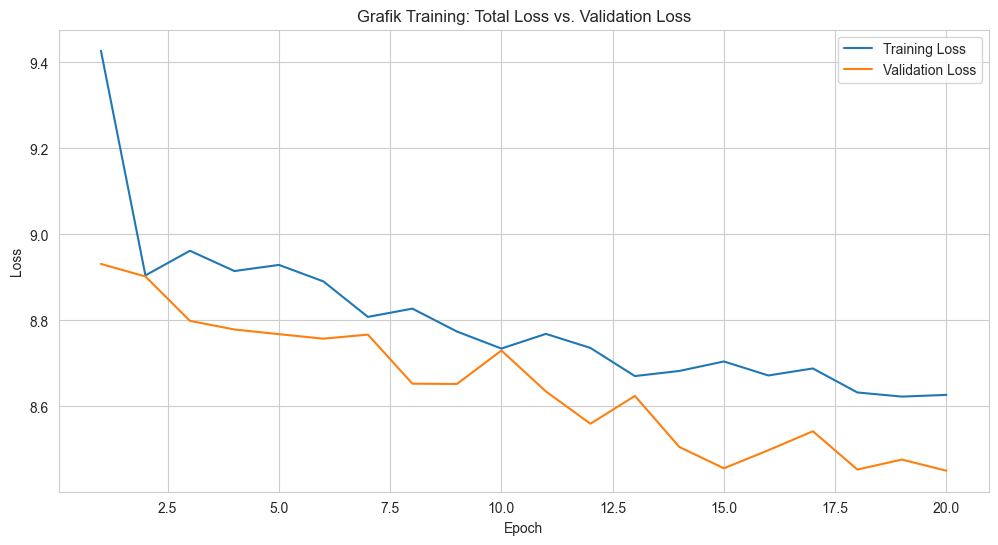

Grafik 'training_loss_plot.png' disimpan.


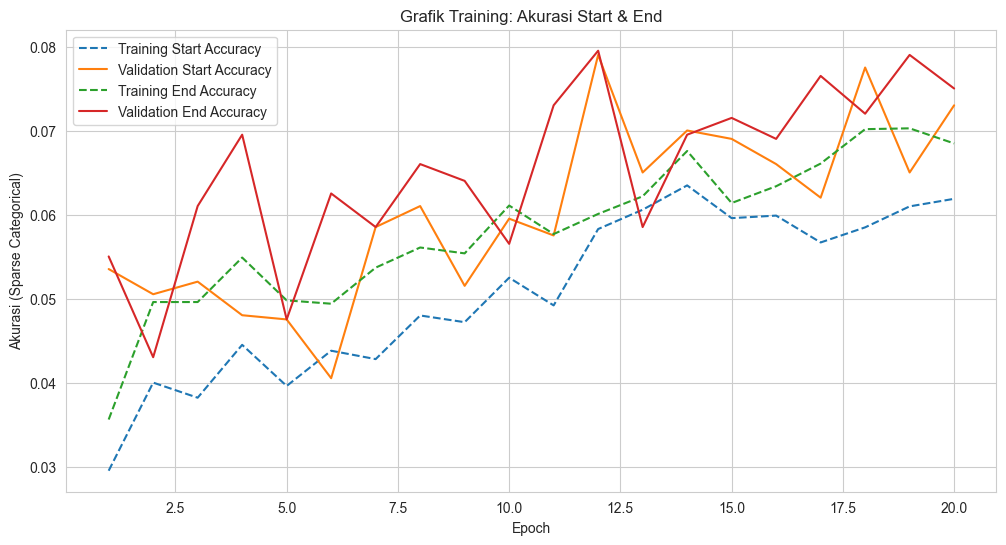

Grafik 'training_accuracy_plot.png' disimpan.


In [ ]:
sns.set_style("whitegrid")

print("Membuat grafik dari objek 'history'...")

try:
    # 1. Konversi history (yang baru saja dibuat) ke DataFrame
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history_df.index + 1
    
    # 2. Plotting: Total Loss
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=history_df, x='epoch', y='loss', label='Training Loss')
    sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss')
    plt.title('Grafik Training: Total Loss vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_loss_plot.png')
    plt.show() # Tampilkan plot
    print("Grafik 'training_loss_plot.png' disimpan.")

    # 3. Plotting: Accuracy (Start & End)
    plt.figure(figsize=(12, 6))
    
    # Ganti nama kolom (jika ada) untuk legenda
    history_df.rename(columns={
        'start_positions_sparse_categorical_accuracy': 'Train Start Acc',
        'val_start_positions_sparse_categorical_accuracy': 'Val Start Acc',
        'end_positions_sparse_categorical_accuracy': 'Train End Acc',
        'val_end_positions_sparse_categorical_accuracy': 'Val End Acc'
    }, inplace=True, errors='ignore')

    # Plot akurasi yang ada di history
    if 'Train Start Acc' in history_df.columns:
        sns.lineplot(data=history_df, x='epoch', y='Train Start Acc', label='Training Start Accuracy', linestyle='--')
    if 'Val Start Acc' in history_df.columns:
        sns.lineplot(data=history_df, x='epoch', y='Val Start Acc', label='Validation Start Accuracy', linestyle='-')
    if 'Train End Acc' in history_df.columns:
        sns.lineplot(data=history_df, x='epoch', y='Train End Acc', label='Training End Accuracy', linestyle='--')
    if 'Val End Acc' in history_df.columns:
        sns.lineplot(data=history_df, x='epoch', y='Val End Acc', label='Validation End Accuracy', linestyle='-')

    plt.title('Grafik Training: Akurasi Start & End')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi (Sparse Categorical)')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_accuracy_plot.png')
    plt.show() # Tampilkan plot
    print("Grafik 'training_accuracy_plot.png' disimpan.")

except NameError as e:
    if 'history' in str(e):
        print("Error: Objek 'history' tidak ditemukan.")
        print("Pastikan Anda menjalankan sel ini TEPAT SETELAH sel model.fit().")
    else:
        print(f"Terjadi error: {e}")
except Exception as e:
    print(f"Terjadi error tak terduga: {e}")

## 🎯 Uji Coba Inferensi Akhir

In [ ]:
konteks_baru = """
Piala Dunia FIFA 2014 adalah Piala Dunia FIFA ke-20, turnamen sepak bola 
internasional yang diadakan di Brasil pada tahun 2014. 
Jerman memenangkan turnamen setelah mengalahkan Argentina 1-0 
di final. Ini adalah gelar Piala Dunia keempat bagi Jerman.
"""

pertanyaan_baru = "Siapa yang memenangkan Piala Dunia 2014?"

jawaban = predict_answer(konteks_baru, pertanyaan_baru, loaded_model, tokenizer, MAX_SEQ_LENGTH)

print(f"Konteks: {konteks_baru}")
print(f"Pertanyaan: {pertanyaan_baru}")
print(f"Jawaban Model: {jawaban}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Konteks: 
Piala Dunia FIFA 2014 adalah Piala Dunia FIFA ke-20, turnamen sepak bola 
internasional yang diadakan di Brasil pada tahun 2014. 
Jerman memenangkan turnamen setelah mengalahkan Argentina 1-0 
di final. Ini adalah gelar Piala Dunia keempat bagi Jerman.

Pertanyaan: Siapa yang memenangkan Piala Dunia 2014?
Jawaban Model: Jerman memenangkan turnamen setelah mengalahkan Argentina 1 - 0 di final . Ini adalah gelar Piala Dunia keempat bagi Jerman
